In [1]:
import os

data_dir = 'C:/Users/write/OneDrive/Deep Learning Data/jena_climate_2009_2016'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]  #0th position is header; 1 onwards is data

print(header)
print('Total records: ', len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Total records:  420551


# Will execute this on CPU

#Note that except "Date Time" rest of columns hold float data.
#While parsing the values we need to exclude "Date Time" values

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    float_data[i, :] = [float(x) for x in line.split(',')[1 :]]    #[1: ] => excluding Date Time values on 0th column

#Within the float_data collection "p (mbar)" is the 0th column, "T (degC)" is the 1st column, and so on

In [3]:
import matplotlib.pyplot as plt

deg_temp = float_data[:, 1]  #all values of "T (degC)" column
plt.plot(range(len(deg_temp)), deg_temp)

#Plot first 10 days
#Temperatures are recorded every 10 mins i.e. 6 records/hr and 6*24 = 144/day

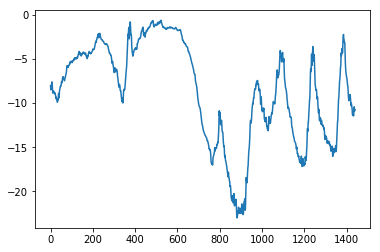

In [4]:
plt.plot(range(1440), deg_temp[: 1440]) #first 10 days records

# Based on 10 days data can we predict next 24 hrs temperatures?
#lookback = 1440 observations (6 * 24 * 10) 
#steps = 6 observations will be sampled at one data point every hr
#delay = 144 Targets will be 24 hrs in the future
#We will use first 200,000 as training data

In [5]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

#At this point first 200,000 records in float_data collection are normalized and can be used for training

# Create Data Generator
>It yields a tuple (samples, targets) where samples is one batch of input data
>and targets us the corresponding array of target temperatures

> data - The original array of floating-point data (float_data)
> lookback - Defines how many timesteps back the input data should go (720 means 5 days, 1440 means 10 days, etc.)
> delay - Defines how many timesteps in the future target should be (144 means 24 hrs given 1 record / 10 mins)
> min_index and max_index - Indices in the data array [float_data] that delimit which timesteps to draw from. 
Helps in data segmentation for training, validation and text.
Note, we normalized first 200,000 records for training
> shuffle - Whether to shuffle the samples or draw them in chronological order. Usually validation and test data are not shuffled in Timeseries problem
> batch_size - The number of samples per batch
> step - The period, in timesteps, at which data is sampled. Here the data is sampled every 10 mins i.e. 6/hr

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = (len(data) - 1) - delay   #index value starts from [len(data) - 1] because index starts from 0
    
    lower_index = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size) 
            #Return a random integer N such that (min_index + lookback) <= N <= max_index
            #Basically shuffling rows within the min and max index values
        else:
            if lower_index + batch_size >= max_index:
                lower_index = min_index + lookback
            rows = np.arange(lower_index, min(lower_index + batch_size, max_index))
            lower_index += len(rows)
        
        #samples(#totalrecords, #readings/day, #columns)
        # '//' is for floor division
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        
        targets = np.zeros((len(rows), ))
        
        #range(start, stop, step)
        #start - Optional. An integer number specifying at which position to start. Default is 0
        #stop - Required. An integer number specifying at which position to end.
        #step - Optional. An integer number specifying the incrementation. Default is 1
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440 # 6 * 24 * 10 => 10 days
step = 6 #number of observations per hour
delay = 144 #target => 6 * 24 => predicting 24 hrs in future
batch_size = 128

train_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 0,
                     max_index = 200000, #first 200000 for training (normalized for training)
                     shuffle = True, #training data is shuffled
                     batch_size = batch_size, 
                     step = step
                     )

#Not shuffling validation and test data
validation_gen = generator(float_data,
                          lookback = lookback,
                          delay = delay,
                          min_index = 200001,
                          max_index = 300000,
                          batch_size = batch_size, 
                          step = step
                          )

test_gen = generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 300001,
                    max_index = None,
                    batch_size = batch_size,
                    step = step)

In [ ]:
#How many steps to draw from validation_gen in order to see the entire validation set
validation_steps = 300000 - 200001 - lookback

#How many steps to draw from test_gen in order to see the entire test set
test_steps = (len(float_data) - 300001 - lookback)


def common_sense_method():
    batch_maes = []
    for step in range(validation_steps):
        samples, targets = next(validation_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return np.mean(batch_maes)

avg_mae = common_sense_method()

celsius_mae = avg_mae * std[1]
print(celsius_mae)

In [8]:
#np.mean(batch_maes) = 0.28969941979609765
#celsius_mae = 2.5645638478601653

validation_steps = 300000 - 200001 - lookback

from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras import optimizers
from keras import losses
from keras import metrics

model = Sequential()
model.add(Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = optimizers.RMSprop(),
             loss = losses.MAE)

history_dense = model.fit_generator(train_gen,
                                   steps_per_epoch = 500,
                                   epochs = 20,
                                   validation_data = validation_gen,
                                   validation_steps = validation_steps)

D:\InstalledSoftware\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 1433s 3s/step - loss: 1.0830 - val_loss: 0.5856
Epoch 2/20
500/500 [==============================] - 1409s 3s/step - loss: 0.4076 - val_loss: 0.3197
Epoch 3/20
500/500 [==============================] - 1550s 3s/step - loss: 0.2930 - val_loss: 0.3154
Epoch 4/20
500/500 [==============================] - 1534s 3s/step - loss: 0.2702 - val_loss: 0.3109
Epoch 5/20
500/500 [==============================] - 1444s 3s/step - loss: 0.2557 - val_loss: 0.3039
Epoch 6/20
500/500 [==============================] - 1262s 3s/step - loss: 0.2457 - val_loss: 0.3345
Epoch 7/20
500/500 [==============================] - 1267s 3s/step - loss: 0.2399 - val_loss: 0.3213
Epoch 8/20
500/500 [==============================] - 1301s 3s/step - loss: 0.2354 - val_loss: 0.3306
Epoch 9/20
500/500 [==============================] - 1373s 3s/step - loss: 0.2307 - val_loss: 0.3390
Epoch 10/20
500/500 [==============================] - 1386s 3s/step - loss: 0.225

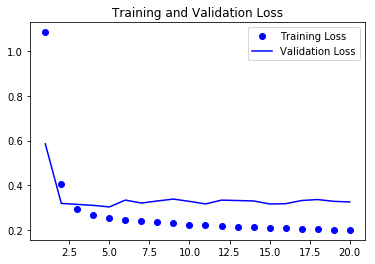

In [9]:
loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
from 